In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA

from Index_weighting_functions import FinancialMetrics, PortfolioOptimization, PortfolioWeighting, PortfolioAnalysis, PortfolioStrategy, KenFrenchIndustryPortfolios

%load_ext autoreload
%autoreload 2

In [2]:
kf_portfolios = KenFrenchIndustryPortfolios(n_inds=49)
ind49_rets = kf_portfolios.get_ind_returns(weighting="vw")["1974":]
ind49_mcap = kf_portfolios.get_ind_market_caps(weights=True)["1974":]
cov = ind49_rets.cov()

In [3]:
ind49_rets.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
1974-01,0.0229,0.0615,-0.0540,-0.0083,0.0301,0.0899,0.0858,-0.0101,-0.0260,0.0965,...,0.0050,0.0048,0.0552,0.0776,0.0144,0.0014,-0.0162,0.1311,0.0083,0.0102
1974-02,0.1382,0.0140,-0.0236,-0.0174,0.0185,-0.0257,-0.0032,-0.0528,-0.0342,0.0230,...,0.0156,0.0787,0.0239,0.0137,-0.0477,0.0165,-0.0219,-0.0249,0.0129,-0.0100
1974-03,-0.0157,-0.0156,-0.0406,-0.0220,-0.0600,0.0517,0.0361,0.0579,-0.0023,-0.0158,...,-0.0151,-0.0485,0.0159,-0.0452,0.0373,-0.0438,-0.0453,-0.0216,-0.0399,-0.0306
1974-04,-0.0926,-0.0265,-0.0415,-0.0366,-0.0277,-0.0749,-0.0796,-0.0646,-0.0419,-0.0477,...,-0.0269,-0.0393,-0.0194,-0.0206,-0.0296,-0.0510,-0.0919,-0.1227,-0.0684,-0.0535
1974-05,-0.0703,-0.0488,-0.0115,-0.0448,0.0559,0.0238,-0.0089,-0.0133,0.0102,-0.0691,...,-0.0130,-0.0469,-0.0390,0.0220,-0.0305,-0.1089,-0.0882,-0.1146,-0.0998,-0.0677


In [4]:
ind49_mcap.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
1974-01,0.000757,0.023874,0.014288,0.006235,0.008435,0.004557,0.002918,0.006314,0.087971,0.003453,...,0.016800,0.014330,0.005279,0.046936,0.006213,0.031837,0.020093,0.001807,0.040329,0.044887
1974-02,0.000773,0.025248,0.013489,0.006172,0.008666,0.004958,0.003160,0.006053,0.085401,0.003770,...,0.016839,0.014344,0.005555,0.050377,0.006280,0.031768,0.019675,0.002004,0.040422,0.045171
1974-03,0.000883,0.025604,0.013220,0.006077,0.008796,0.004838,0.003161,0.005738,0.082550,0.003859,...,0.017098,0.015476,0.005700,0.051104,0.006005,0.032384,0.019254,0.001954,0.040982,0.044799
1974-04,0.000891,0.025714,0.012954,0.006074,0.008467,0.005081,0.003358,0.006207,0.084434,0.003871,...,0.017267,0.015057,0.005921,0.049980,0.006376,0.031559,0.018815,0.001956,0.040202,0.044434
1974-05,0.000846,0.026251,0.013041,0.006144,0.008643,0.004822,0.003241,0.006097,0.084895,0.003852,...,0.017598,0.015178,0.006092,0.051341,0.006481,0.031371,0.017868,0.001795,0.039215,0.044104


## Risk Parity

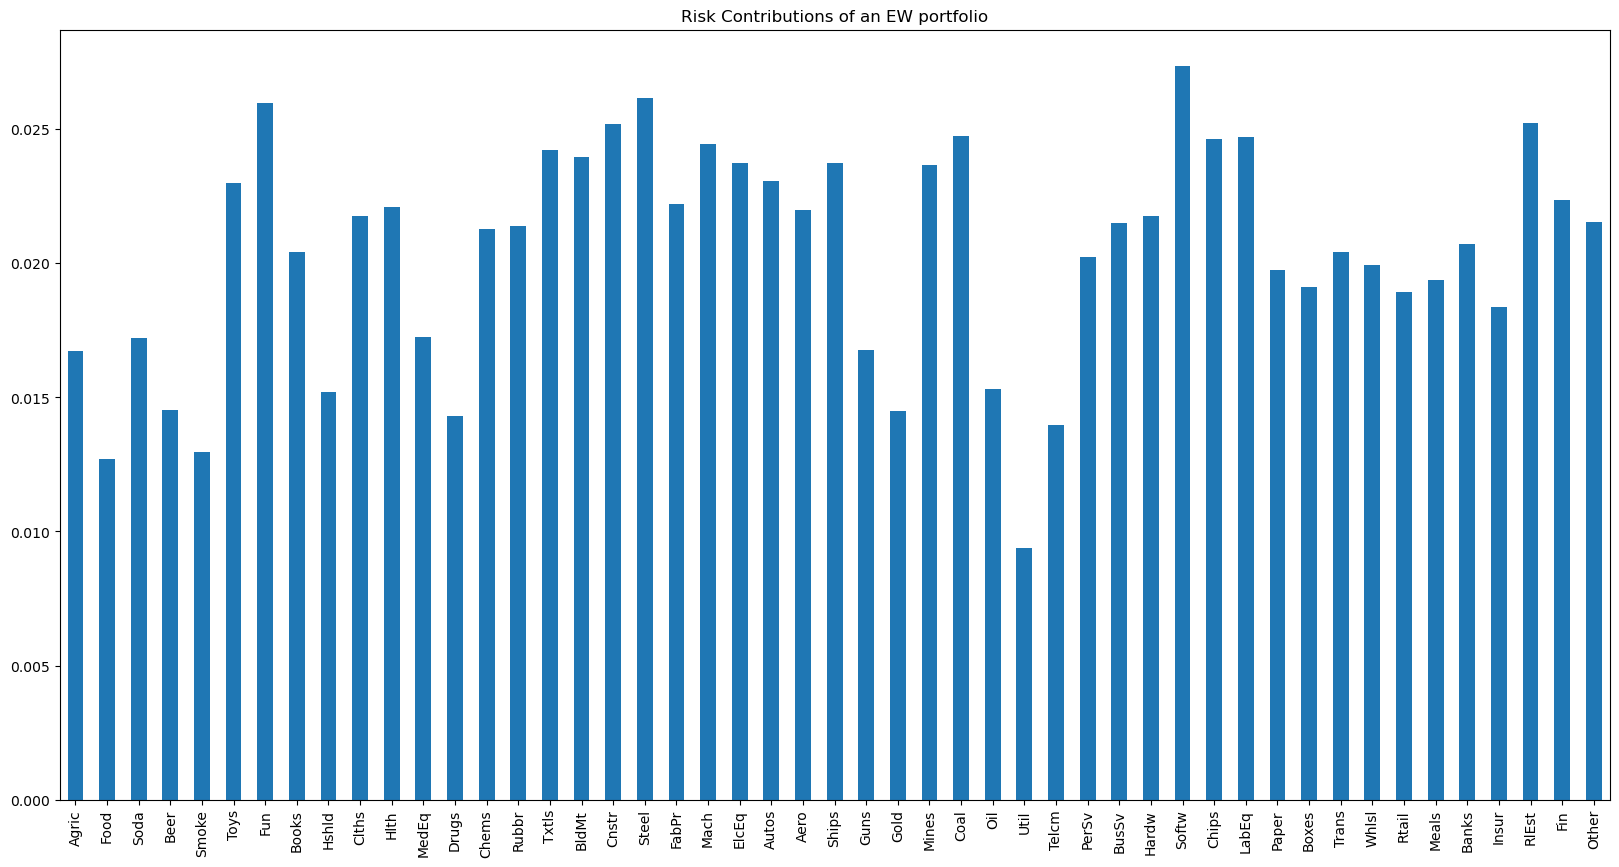

In [5]:
plt.figure(figsize=(20, 10))
PortfolioOptimization.risk_contribution(PortfolioWeighting.weight_ew(ind49_rets), cov).plot.bar(title="Risk Contributions of an EW portfolio");

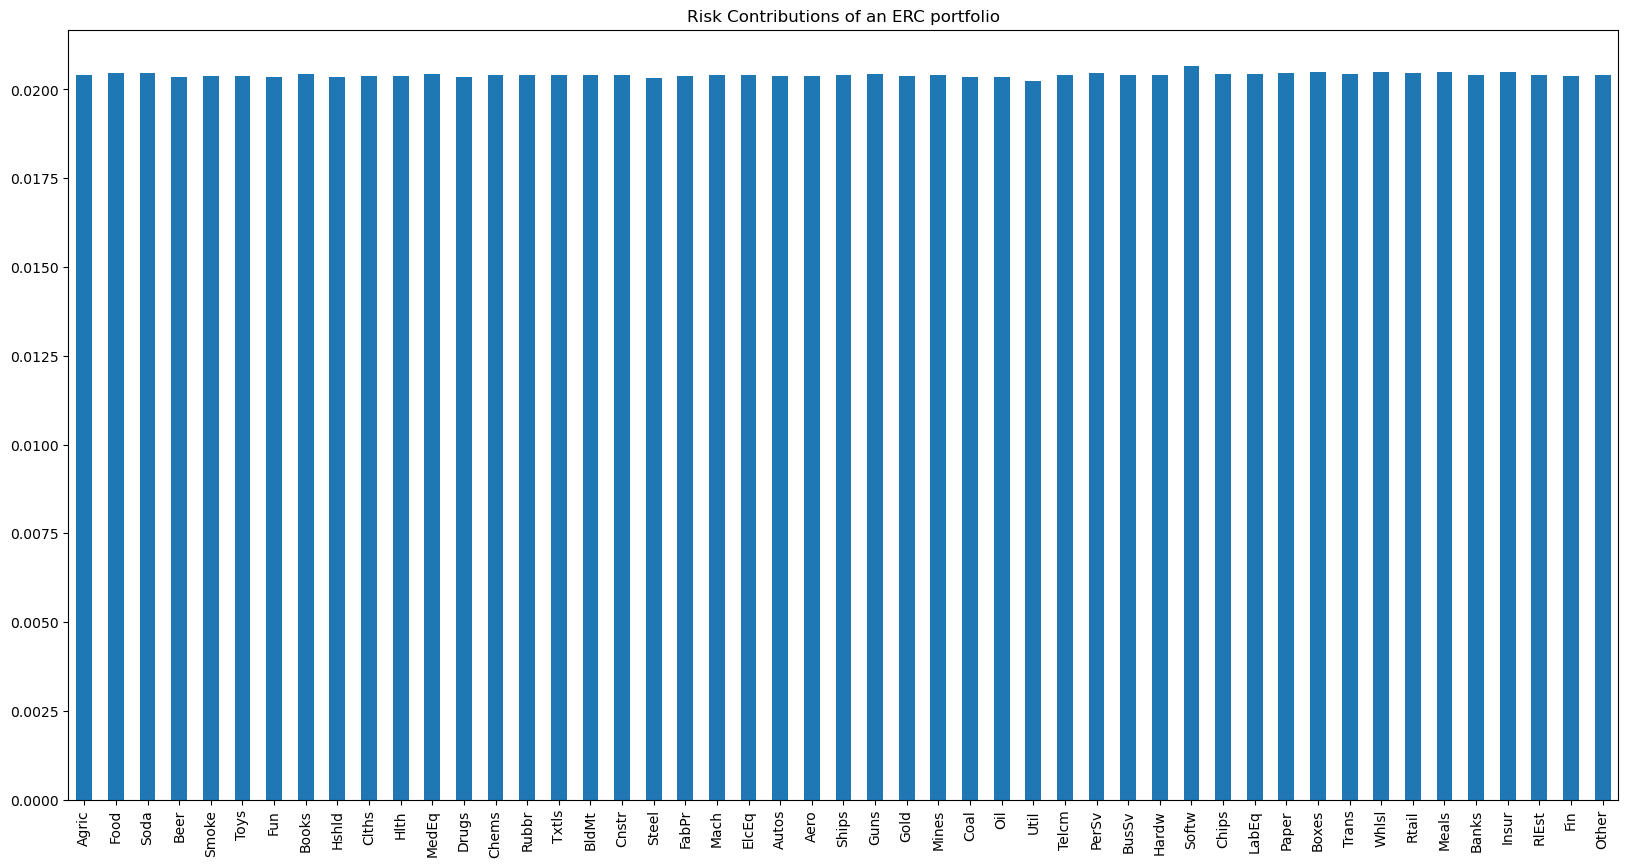

In [6]:
plt.figure(figsize=(20, 10))
PortfolioOptimization.risk_contribution(PortfolioOptimization.equal_risk_contributions(cov), cov).plot.bar(title="Risk Contributions of an ERC portfolio");

## K-Means

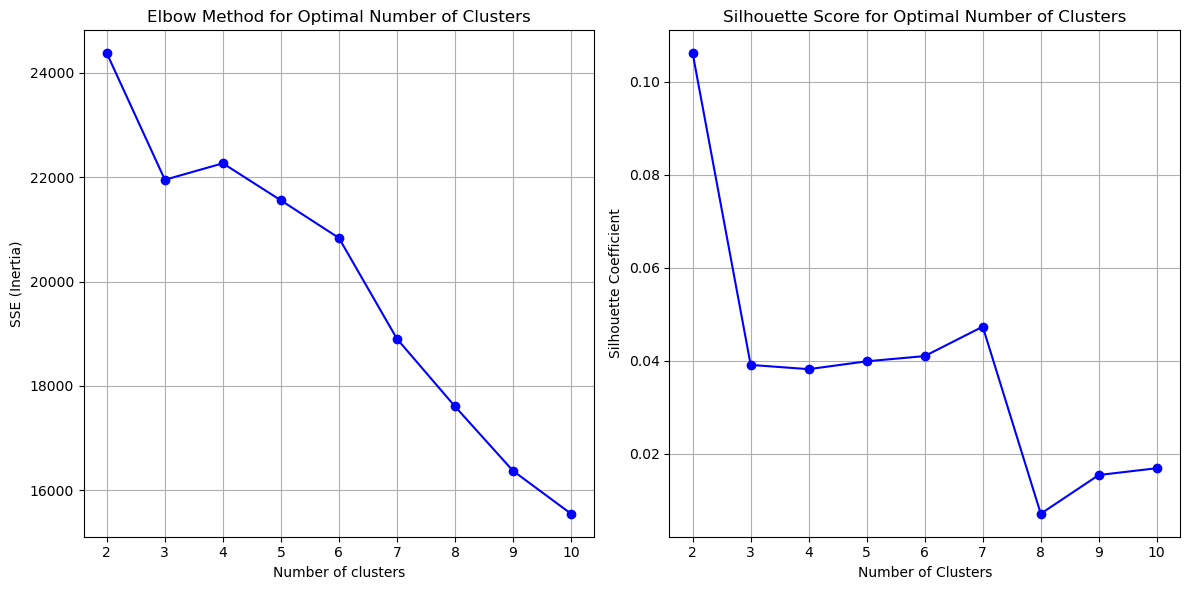

In [7]:
r_transposed = ind49_rets.transpose().dropna()
scaler = StandardScaler()
r_scaled = scaler.fit_transform(r_transposed)
sse = {}
silhouette_coefficients = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(r_scaled)
    sse[k] = kmeans.inertia_
    score = silhouette_score(r_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(list(sse.keys()), list(sse.values()), 'bo-')
plt.xlabel("Number of clusters")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xticks(K_range)
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_coefficients, 'bo-')
plt.xticks(K_range)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title("Silhouette Score for Optimal Number of Clusters")
plt.grid(True)
plt.tight_layout()
plt.show()

## Hierarchical Clustering

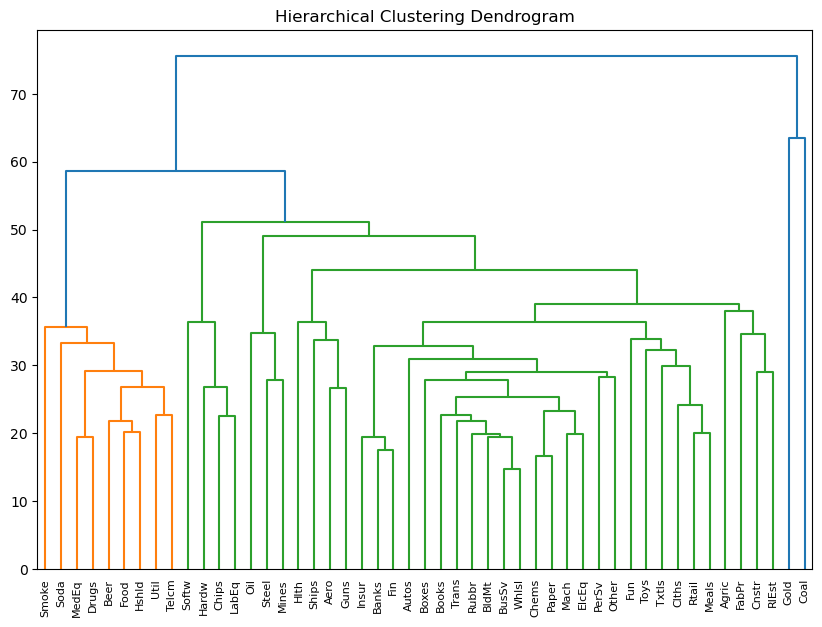

In [8]:
Z = linkage(r_scaled, method='ward')

plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(Z, labels=r_transposed.index, leaf_rotation=90, leaf_font_size=8)
plt.show()

In [9]:
max_d = 7
clusters = fcluster(Z, max_d, criterion='distance')
asset_cluster = pd.DataFrame({'asset': r_transposed.index, 'cluster': clusters})

#print(asset_cluster.sort_values('cluster'))

In [10]:
k = 6
clusters = fcluster(Z, k, criterion='maxclust')
asset_cluster_k = pd.DataFrame({'asset': r_transposed.index, 'cluster': clusters})

#print(asset_cluster_k.sort_values('cluster'))

## PCA

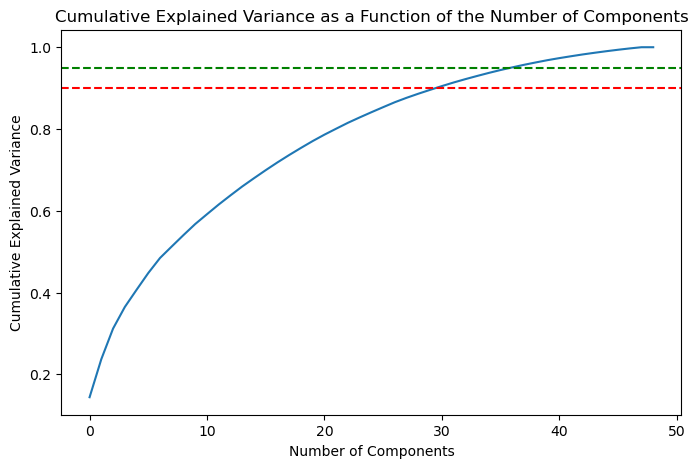

In [11]:
pca = PCA().fit(r_scaled)
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.axhline(y=0.95, color='g', linestyle='--')
plt.show()

In [12]:
for i, cum_var in enumerate(cumulative_explained_variance):
    if cum_var >= 0.9:
        print(f"Number of components for 90% explained variance: {i+1}")
        break

Number of components for 90% explained variance: 31


## Strategies

In [13]:
strategies = {
    "CW": lambda r: PortfolioWeighting.weight_cw(r, cap_weights=ind49_mcap),
    "EW": lambda r: PortfolioWeighting.weight_ew(r),
    "EW-Tethered": lambda r: PortfolioWeighting.weight_ew(r, cap_weights=ind49_mcap, max_cw_mult=5, microcap_threshold=.019),
    "GMV": lambda r: PortfolioWeighting.weight_gmv(r, cov_estimator=PortfolioOptimization.sample_cov),
    "GMV-CC": lambda r: PortfolioWeighting.weight_gmv(r, cov_estimator=PortfolioOptimization.cc_cov),
    "GMV-SC": lambda r: PortfolioWeighting.weight_gmv(r, cov_estimator=PortfolioOptimization.shrinkage_cov, delta=0.8),
    "ERC": lambda r: PortfolioWeighting.weight_erc(r, cov_estimator=PortfolioOptimization.sample_cov),
    "ERC-A": lambda r: PortfolioWeighting.weight_erc(r, cov_estimator=PortfolioOptimization.cc_cov),
    "ERC-B": lambda r: PortfolioWeighting.weight_erc(r, cov_estimator=PortfolioOptimization.shrinkage_cov, delta=0.4),
    "MCA": lambda r: PortfolioWeighting.weight_min_corr(r),
    "MaxDiv": lambda r: PortfolioWeighting.weight_max_div(r),
    "MOM": lambda r: PortfolioWeighting.weight_mom(r, lookback_period=12),
    "K-Means": lambda r: PortfolioWeighting.weight_kmeans(r, n_clusters=6),
    "Hier Clust": lambda r: PortfolioWeighting.weight_hier(r, n_clusters=27),
    "HRP": lambda r: PortfolioWeighting.weight_hrp(r),
    "PCA": lambda r: PortfolioWeighting.weight_pca(r, n_components=31),
    "Tail Risk": lambda r: PortfolioWeighting.weight_trp(r, alpha=0.05),
    "Wavelet": lambda r: PortfolioWeighting.weight_wavelet(r, wavelet_name='bior3.5', max_level=4),
    "Algo": lambda r: PortfolioWeighting.weight_algo(r),
    "Random Forest": lambda r: PortfolioWeighting.weight_rf(r, lookback_periods=24),
    "MSR": lambda r: PortfolioWeighting.weight_msr(r, risk_free_rate=0.03, periods_per_year=12)
}

portfolio_strategy = PortfolioStrategy(ind49_rets)
for name, strategy in strategies.items():
    wts, btr = portfolio_strategy.add_strategy(name, strategy)

## Summary Stats

In [14]:
FinancialMetrics.summary_stats(btr.dropna())

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown,Net Profit to Worst Drawdown
CW,0.1173,0.1512,0.1143,-0.7435,5.3467,0.0706,0.0682,0.0978,1.6625,0.5619,0.7400,0.1695,0.6734,-0.5012,166.5793
EW,0.1236,0.1608,0.1235,-0.7571,6.6450,0.0635,0.0715,0.1040,1.9483,0.5665,0.7383,0.1724,0.9339,-0.5283,198.5728
EW-Tethered,0.1256,0.1499,0.1113,-0.6703,5.1883,0.0667,0.0662,0.0952,1.8826,0.6206,0.8304,0.1871,0.8953,-0.4973,226.5880
GMV,0.1141,0.1172,0.0878,-0.6230,5.6475,0.0425,0.0499,0.0731,2.6854,0.6982,0.9336,0.2142,1.0812,-0.3820,194.4157
GMV-CC,0.1230,0.1181,0.0854,-0.4760,4.5199,0.0466,0.0492,0.0714,2.6373,0.7658,1.0595,0.2573,1.4057,-0.3516,291.3344
GMV-SC,0.1223,0.1173,0.0846,-0.4609,4.5612,0.0465,0.0486,0.0705,2.6299,0.7662,1.0614,0.2515,1.3885,-0.3572,280.1532
ERC,0.1236,0.1498,0.1177,-0.8425,6.8759,0.0582,0.0667,0.0973,2.1236,0.6080,0.7753,0.1814,0.9886,-0.5020,208.8619
ERC-A,0.1248,0.1540,0.1204,-0.8245,6.7422,0.0609,0.0687,0.1003,2.0509,0.5989,0.7673,0.1790,0.9740,-0.5155,212.3436
ERC-B,0.1245,0.1517,0.1190,-0.8360,6.8117,0.0596,0.0676,0.0987,2.0877,0.6064,0.7737,0.1812,0.9879,-0.5076,213.3236
MCA,0.1191,0.2683,0.1566,0.7743,6.5803,0.1054,0.0915,0.1434,1.1308,0.3230,0.5531,0.1405,0.3589,-0.6168,144.6428


In [15]:
PortfolioAnalysis.plot_cumulative_returns(btr, title="Portfolio Evolution")

In [20]:
"""
for date in wts.index:
    current_data = wts.loc[date]
    weights_df = pd.DataFrame()
    for strategy, values in current_data.items():
        for asset, weight in values.items():
            if strategy not in weights_df.columns:
                weights_df[strategy] = pd.Series(dtype=float)
            if asset not in weights_df.index:
                weights_df.loc[asset] = pd.Series(dtype=float)
            weights_df.at[asset, strategy] = weights_df.at[asset, strategy] + weight if pd.notna(weights_df.at[asset, strategy]) else weight
    PortfolioAnalysis.plot_weights(weights_df, title="Portfolio Weights - {}".format(date))
"""

'\nfor date in wts.index:\n    current_data = wts.loc[date]\n    weights_df = pd.DataFrame()\n    for strategy, values in current_data.items():\n        for asset, weight in values.items():\n            if strategy not in weights_df.columns:\n                weights_df[strategy] = pd.Series(dtype=float)\n            if asset not in weights_df.index:\n                weights_df.loc[asset] = pd.Series(dtype=float)\n            weights_df.at[asset, strategy] = weights_df.at[asset, strategy] + weight if pd.notna(weights_df.at[asset, strategy]) else weight\n    PortfolioAnalysis.plot_weights(weights_df, title="Portfolio Weights - {}".format(date))\n'

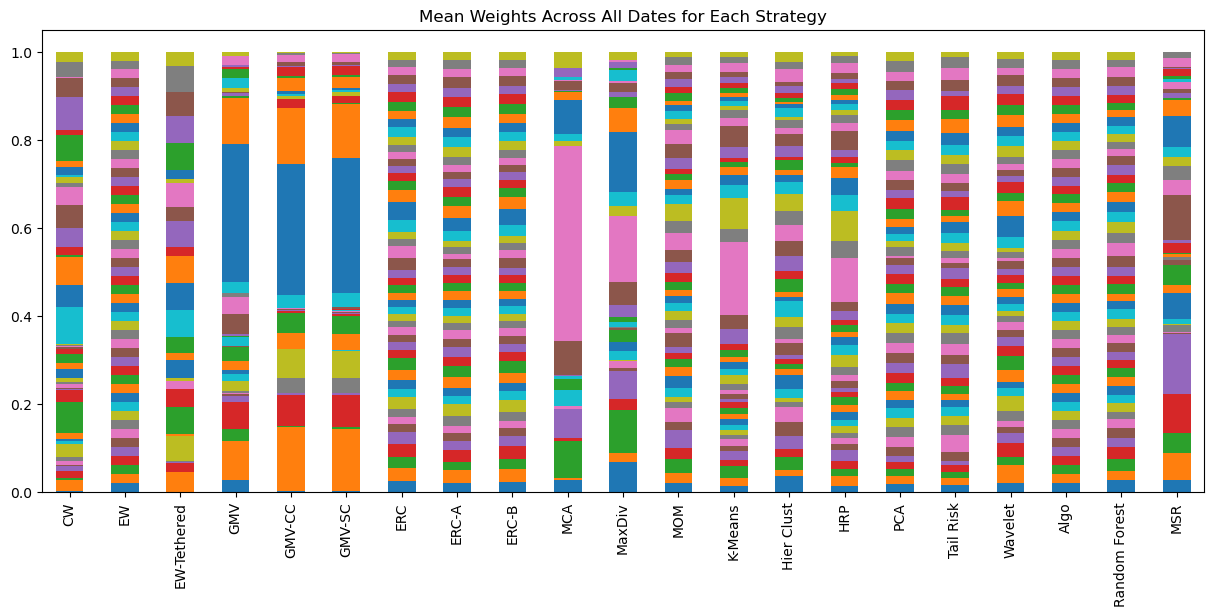

In [17]:
mean_weights = pd.DataFrame()
for column in wts.columns:
    mean_weights[column] = pd.DataFrame(list(wts[column])).mean()

PortfolioAnalysis.plot_weights(mean_weights, title="Mean Weights Across All Dates for Each Strategy")

In [18]:
PortfolioAnalysis.print_tracking_errors(btr['CW'], EW=btr['EW'], EW_Tethered=btr['EW-Tethered'], GMV=btr['GMV'], GMV_CC=btr['GMV-CC'], GMV_SC=btr['GMV-SC'], ERC=btr['ERC'], ERC_A=btr['ERC-A'], ERC_B=btr['ERC-B'], MCA=btr['MCA'], MaxDiv=btr['MaxDiv'], MOM=btr['MOM'], K_Means=btr['K-Means'], Hier_Clust=btr['Hier Clust'], HRP=btr['HRP'], PCA=btr['PCA'], Tail_Risk=btr['Tail Risk'], Wavelet=btr['Wavelet'], Algo=btr['Algo'], Random_Forest=btr['Random Forest'], MSR=btr['MSR'])

Tracking error for EW is: 0.2856
Tracking error for EW_Tethered is: 0.1553
Tracking error for GMV is: 0.5977
Tracking error for GMV_CC is: 0.6206
Tracking error for GMV_SC is: 0.6218
Tracking error for ERC is: 0.2744
Tracking error for ERC_A is: 0.2635
Tracking error for ERC_B is: 0.2655
Tracking error for MCA is: 1.5898
Tracking error for MaxDiv is: 0.5885
Tracking error for MOM is: 0.5576
Tracking error for K_Means is: 0.6291
Tracking error for Hier_Clust is: 0.3631
Tracking error for HRP is: 0.4945
Tracking error for PCA is: 0.2908
Tracking error for Tail_Risk is: 0.3670
Tracking error for Wavelet is: 0.2596
Tracking error for Algo is: 0.2866
Tracking error for Random_Forest is: 0.2979
Tracking error for MSR is: 0.6228


In [19]:
PortfolioAnalysis.print_information_ratios(btr['CW'], EW=btr['EW'], EW_Tethered=btr['EW-Tethered'], GMV=btr['GMV'], GMV_CC=btr['GMV-CC'], GMV_SC=btr['GMV-SC'], ERC=btr['ERC'], ERC_A=btr['ERC-A'], ERC_B=btr['ERC-B'], MCA=btr['MCA'], MaxDiv=btr['MaxDiv'], MOM=btr['MOM'], K_Means=btr['K-Means'], Hier_Clust=btr['Hier Clust'], HRP=btr['HRP'], PCA=btr['PCA'], Tail_Risk=btr['Tail Risk'], Wavelet=btr['Wavelet'], Algo=btr['Algo'], Random_Forest=btr['Random Forest'], MSR=btr['MSR'])

Information Ratio for EW is: 0.0465
Information Ratio for EW_Tethered is: 0.0856
Information Ratio for GMV is: -0.0232
Information Ratio for GMV_CC is: 0.0015
Information Ratio for GMV_SC is: -0.0006
Information Ratio for ERC is: 0.0368
Information Ratio for ERC_A is: 0.0503
Information Ratio for ERC_B is: 0.0455
Information Ratio for MCA is: 0.0284
Information Ratio for MaxDiv is: -0.0162
Information Ratio for MOM is: 0.0977
Information Ratio for K_Means is: 0.0341
Information Ratio for Hier_Clust is: 0.0280
Information Ratio for HRP is: 0.0285
Information Ratio for PCA is: 0.0525
Information Ratio for Tail_Risk is: 0.1005
Information Ratio for Wavelet is: 0.0709
Information Ratio for Algo is: 0.0499
Information Ratio for Random_Forest is: 0.0421
Information Ratio for MSR is: 0.0459
